#Import necessary packages


In [44]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from glob import glob
from tqdm import tqdm
import tensorflow as tf

#Mount Drive

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Reading in Images

In [46]:
cat_files = glob('/content/drive/MyDrive/DatasetForColab/Animals/cat/*.png')
panda_files = glob('/content/drive/MyDrive/DatasetForColab/Animals/panda/*.png')
dolphin_files = glob('/content/drive/MyDrive/DatasetForColab/Animals/dolphin/*.png')

In [47]:
print(len(cat_files))
print(len(panda_files))
print(len(dolphin_files))

432
216
216


In [48]:
path = '/content/drive/MyDrive/DatasetForColab/Animals/'

In [49]:
categories = os.listdir(path)

In [50]:
print(categories)

['cat', 'dolphin', 'panda']


# Preprocess the dataset

In [51]:
dataset = []

In [52]:
for category in categories:
    data_path = os.path.join(path, category)
    print("Loading from:", data_path)
    count = 0

    for img in os.listdir(data_path):
        if count >= 200:
            break

        img_path = os.path.join(data_path, img)
        img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img_array is not None:
            img_resized = cv2.resize(img_array, (256, 256))  # Now safe, img_array not None
            dataset.append([img_resized, category])
            count += 1
        else:
            print(f"Warning: Failed to load image {img_path}")


Loading from: /content/drive/MyDrive/DatasetForColab/Animals/cat
Loading from: /content/drive/MyDrive/DatasetForColab/Animals/dolphin
Loading from: /content/drive/MyDrive/DatasetForColab/Animals/panda


In [53]:
len(dataset)

600

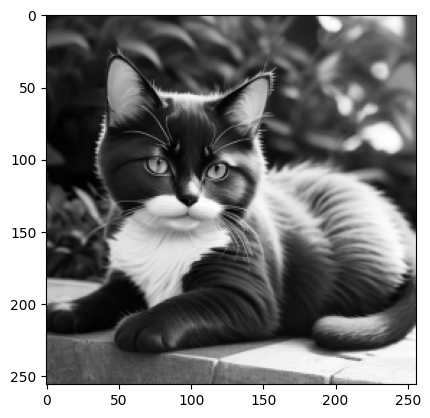

In [54]:
plt.imshow(dataset[90][0], cmap='gray')

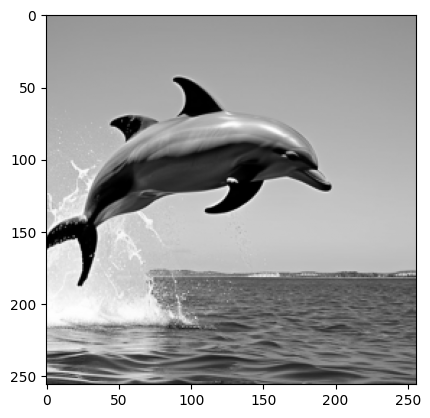

In [55]:
random.shuffle(dataset)
plt.imshow(dataset[90][0], cmap='gray')

# 5 Fold Cross Validation

In [58]:
folds = []
start_index = 0
count = len(dataset) / 5
for i in range(0,5):
  folds.append(dataset[start_index:int(count)])
  start_index = int(count)
  count += len(dataset) / 5

In [59]:
print(len(folds))
print(len(folds[0]))

5
120


# k-NN


In [74]:
def mostCommonElement(lst,k):
  lst = [x[1] for x in lst]
  most_common_element = Counter(lst[0:k]).most_common(1)[0][0]
  return most_common_element
average_accuracies = []
all_fold_accuracies = []  # Store fold accuracies for each k

for k in range(1, 61, 2):
  fold_accuracies = []  # Reset here for every k
  for i in range(5):
    prediction = []
    valid_dataset = folds[i]
    train_dataset = [item for j in range(5) if j != i for item in folds[j]]

    for valid_rows in valid_dataset:
      distance_matrix = []
      valid_img, valid_label = valid_rows[0], valid_rows[1]

      for train_rows in train_dataset:
        train_img, train_label = train_rows[0], train_rows[1]
        l2_distance = np.sqrt(np.sum(np.square(np.array(train_img) - np.array(valid_img))))
        distance_matrix.append([l2_distance, train_label])

      distance_matrix = sorted(distance_matrix)
      predicted_label = mostCommonElement(distance_matrix, k)

      if valid_label == predicted_label:
        prediction.append(1)
      else:
        prediction.append(0)

    accuracy = sum(prediction) / len(prediction)
    fold_accuracies.append(accuracy)

  average_accuracies.append(sum(fold_accuracies) / len(fold_accuracies))
  all_fold_accuracies.append(fold_accuracies)

In [75]:
print("Number of k values:", len(average_accuracies))
print("Number of k value groups in all_fold_accuracies:", len(all_fold_accuracies))
print("Total fold accuracies:", sum(len(x) for x in all_fold_accuracies))

Number of k values: 30
Number of k value groups in all_fold_accuracies: 30
Total fold accuracies: 150


In [76]:
average_accuracies = [round(num,2) for num in average_accuracies]
all_fold_accuracies = [[round(num, 2) for num in fold] for fold in all_fold_accuracies]

for idx, average_accuracy in enumerate(average_accuracies):
    k_val = 1 + idx * 2  # Because you're using k from 1 to 30 with step of 2
    print(f"For k={k_val}, Average Accuracy = {average_accuracy}")

For k=1, Average Accuracy = 0.72
For k=3, Average Accuracy = 0.76
For k=5, Average Accuracy = 0.78
For k=7, Average Accuracy = 0.78
For k=9, Average Accuracy = 0.79
For k=11, Average Accuracy = 0.78
For k=13, Average Accuracy = 0.78
For k=15, Average Accuracy = 0.78
For k=17, Average Accuracy = 0.79
For k=19, Average Accuracy = 0.78
For k=21, Average Accuracy = 0.76
For k=23, Average Accuracy = 0.77
For k=25, Average Accuracy = 0.77
For k=27, Average Accuracy = 0.77
For k=29, Average Accuracy = 0.75
For k=31, Average Accuracy = 0.75
For k=33, Average Accuracy = 0.75
For k=35, Average Accuracy = 0.74
For k=37, Average Accuracy = 0.75
For k=39, Average Accuracy = 0.74
For k=41, Average Accuracy = 0.75
For k=43, Average Accuracy = 0.75
For k=45, Average Accuracy = 0.75
For k=47, Average Accuracy = 0.75
For k=49, Average Accuracy = 0.74
For k=51, Average Accuracy = 0.75
For k=53, Average Accuracy = 0.74
For k=55, Average Accuracy = 0.74
For k=57, Average Accuracy = 0.74
For k=59, Average A

In [77]:
flat_fold_accuracies = [acc for fold in all_fold_accuracies for acc in fold]

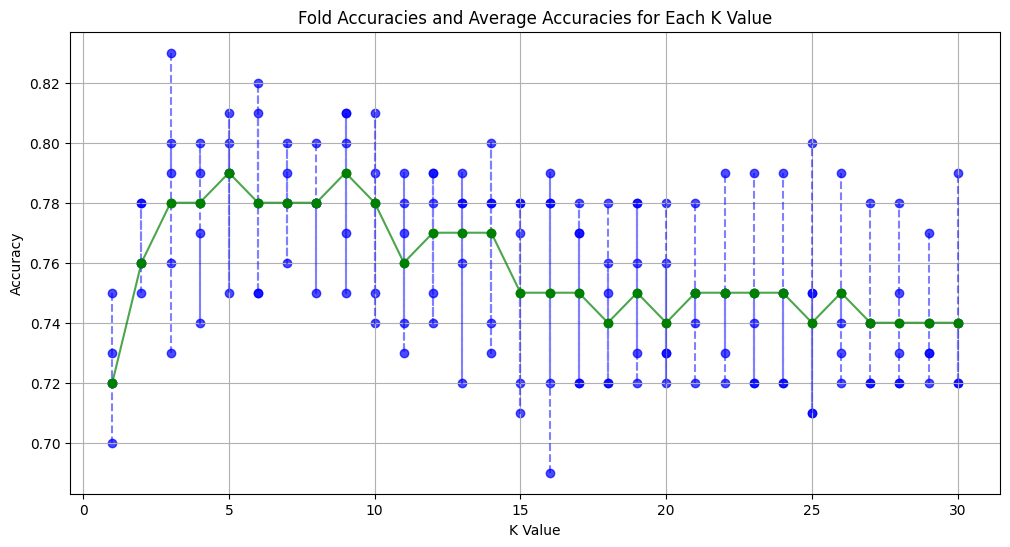

In [78]:
folds_per_k = 5
num_k_values = len(average_accuracies)
plt.figure(figsize=(12, 6))

for k in range(num_k_values):
    start = k * folds_per_k
    end = start + folds_per_k
    plt.scatter([k + 1] * folds_per_k, flat_fold_accuracies[start:end], color='blue', alpha=0.7)
    plt.plot([k + 1] * folds_per_k, flat_fold_accuracies[start:end], linestyle='--', color='blue', alpha=0.5)

plt.plot(range(1, num_k_values + 1), average_accuracies, color='green', marker='o', label='Average Accuracy', alpha=0.7)
plt.scatter(range(1, num_k_values + 1), average_accuracies, color='green', zorder=10)

plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.title('Fold Accuracies and Average Accuracies for Each K Value')
plt.grid(True)
plt.show()